# Demo SEA data calculations
This demonstrates the use of low-level routines to replicate signal analysis performed by SEA.

Each analysis product is returned as a `xarray.DataArray`. At the end, they are merged into a single `xarray.Dataset` containing all of the different data results along with their labels, coordinates, and metadata.

### Generate fake data

In [1]:
from edge_analyzer import channel_waveform
from scipy import signal
from edge_analyzer.io import simulated_awgn
from iqwaveform import fourier

duration = 0.2
sample_rate_Hz = 15.36e6
analysis_bandwidth_Hz = 10e6

raw_iq = simulated_awgn(
    duration, sample_rate_Hz, power=sample_rate_Hz / analysis_bandwidth_Hz
)

### Analysis bandpass filter

In [2]:
iq = fourier.ola_filter(
    raw_iq,
    fs=sample_rate_Hz,
    noverlap=1024,
    window='hamming',
    passband=(-analysis_bandwidth_Hz / 2, analysis_bandwidth_Hz / 2),
)

In [3]:
%%timeit -n1 -r1
fourier.ola_filter(
    raw_iq,
    fs=sample_rate_Hz,
    noverlap=1024,
    window='hamming',
    passband=(-analysis_bandwidth_Hz / 2, analysis_bandwidth_Hz / 2),
)

60.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Channel power time-series

In [4]:
pvt = channel_waveform.power_time_series(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
).to_xarray()

In [5]:
%%timeit -n1 -r1

channel_waveform.power_time_series(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
).to_xarray()

25.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


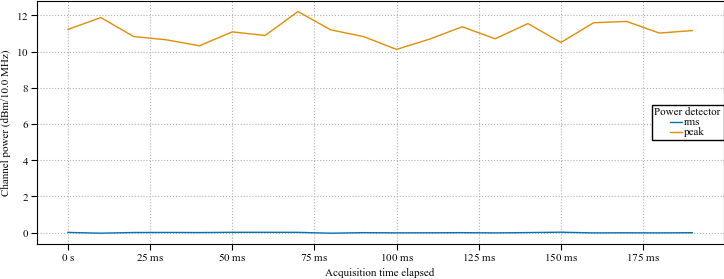

In [6]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from edge_analyzer import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [7]:
cyclic_power = channel_waveform.cyclic_channel_power(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

In [8]:
%%timeit -n1 -r1
cyclic_power = channel_waveform.cyclic_channel_power(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

24.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


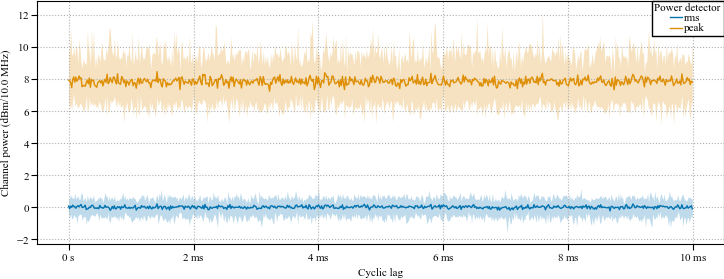

In [10]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [11]:
frequency_resolution = 15e3
spectrum_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1]

spectrum = channel_waveform.persistence_spectrum(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
    dB=True,
).to_xarray()

In [12]:
%%timeit -n1 -r1

frequency_resolution = 15e3
spectrum_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1]

spectrum = channel_waveform.persistence_spectrum(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
    dB=True,
).to_xarray()

71.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


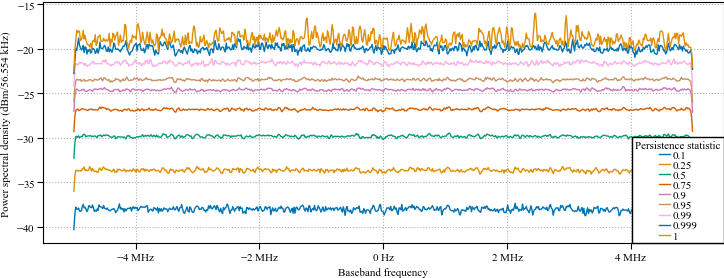

In [13]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

### Amplitude Probability Distribution

In [14]:
apd_bins = dict(power_low=-60.0, power_high=15.0, power_count=55 * 4 + 1)

apd = channel_waveform.amplitude_probability_distribution(
    iq, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
).to_xarray()

In [15]:
%%timeit -n1 -r1

channel_waveform.amplitude_probability_distribution(
    iq, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
).to_xarray()

145 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


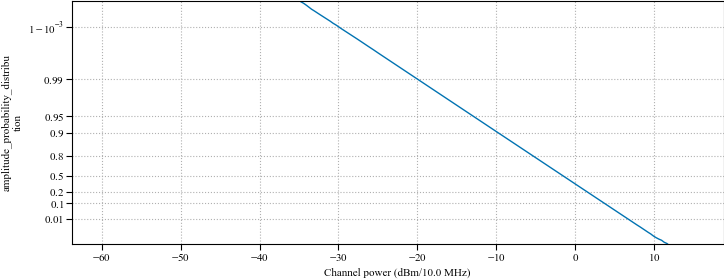

In [16]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Putting it all together

In [17]:
from edge_analyzer import channel_waveform

analysis_spec = {
    'power_time_series': {
        'detector_period': 10e-3,
        'detectors': ('rms', 'peak')
    },
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
}

filter_spec = {
    # 'iir': {
    #     # an IIR bandpass filter
    #     'passband_ripple_dB': 0.1,
    #     'stopband_attenuation_dB': 90,
    #     'transition_bandwidth_Hz': 250e3,
    # },
    'ola': {
        # a bandpass filter implemented with stft overlap-and-add 
        'noverlap': 1024,
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
    },
}

channel_waveform.from_spec(
    raw_iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

<xarray.Dataset> Size: 91kB
Dimensions:                             (power_detector: 2, time_elapsed: 20,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         channel_power: 221,
                                         cyclic_statistic: 3, cyclic_lag: 600)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * channel_power                       (channel_power) float64 2kB -40.0 ......
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
Data variables:
    power_time_series                   (power_detector, time_elapsed) float64 320B ...
    persistence_spectrum                (persistence_statistic, baseband_frequency) float64 48kB ...
    amplitude_probability_distribution  (channel_power) float64 2kB 0.9999 .....
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float64 29kB ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'noverlap': 1024, 'window': 'hamming'}}

In [19]:
%%timeit -n1 -r1

channel_waveform.from_spec(
    raw_iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

307 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
